##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models. This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

In [2]:
import matplotlib.pylab as plt

!pip install -q tf-nightly
import tensorflow as tf

In [3]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

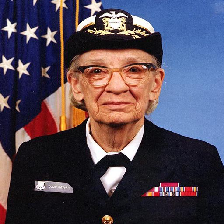

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

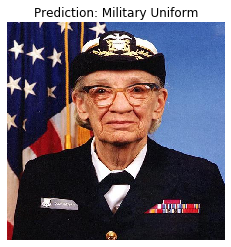

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning USING MNIST FASHION DATA (modification**)

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the MNIST fashion dataset:

In [12]:
#*MODIFIED*
#COPY FROM CLASSIFICATION#
import tensorflow as tf
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [13]:
#*MODIFIED*
####Helper Functions####
def convert_to_color(images, size=(224,224)):
    images_2 = np.stack((images,)*3, axis=-1)
    images_3 = tf.image.resize(
        images_2, 
        size, 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return images_3


def convert_to_one_hot(labels):
    rows = np.arange(labels.size)
    one_hot = np.zeros((labels.size, labels.max()+1))
    one_hot[rows, labels] = 1
    return one_hot

In [14]:
#*MODIFIED*
#COPY FROM CLASSIFICATION#

class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [15]:
#*MODIFIED*
#NEW: convert MNIST FASHION TRAIN IMAGES TO COLOR 
train_images = convert_to_color(train_images)

train_images.shape

TensorShape([60000, 224, 224, 3])

In [16]:
#*MODIFIED*
#NEW: CONVERT TRAIN LABELS TO ONE-HOT FORMAT
train_labels = convert_to_one_hot(train_labels)


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [17]:
#*MODIFIED*
# rescale train images to values [0,1], batch size = 64 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow(train_images, train_labels, batch_size = 64)

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [18]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 10)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [19]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(64, 1001)

In [20]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['window shade', 'crossword puzzle', 'window shade', 'spotlight',
       'crossword puzzle', 'crossword puzzle', 'crossword puzzle',
       'crossword puzzle', 'spotlight', 'container ship',
       'crossword puzzle', 'crossword puzzle', 'crossword puzzle',
       'pedestal', 'window shade', 'digital clock', 'pedestal',
       'crossword puzzle', 'spotlight', 'window shade',
       'crossword puzzle', 'crossword puzzle', 'window shade',
       'crossword puzzle', 'digital clock', 'lampshade', 'shower curtain',
       'digital clock', 'window shade', 'crossword puzzle',
       'picket fence', 'shower curtain', 'spotlight', 'shower curtain',
       'crossword puzzle', 'window shade', 'picket fence',
       'digital clock', 'shower curtain', 'shower curtain',
       'crossword puzzle', 'picket fence', 'maze', 'picket fence',
       'crossword puzzle', 'crossword puzzle', 'shower curtain',
       'crossword puzzle', 'digital clock', 'shower curtain',
       'crossword puzzle', 'spotl

Now check how these predictions line up with the images:

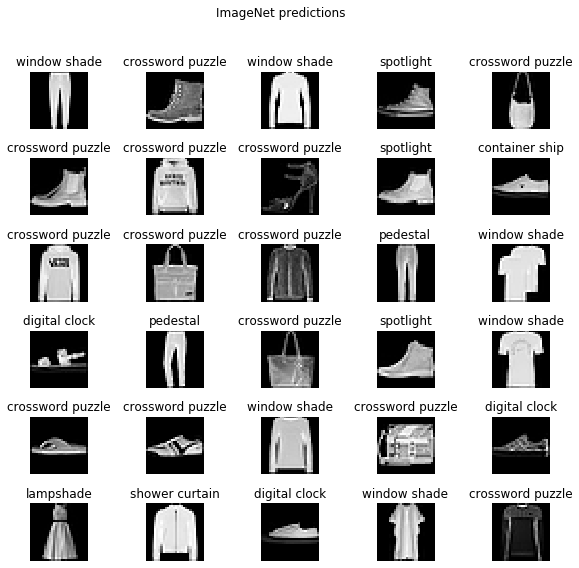

In [21]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [22]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [23]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [24]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(64, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [25]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [26]:
#*MODIFIED*
#change the number of classes to 10 
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(len(class_names))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
predictions = model(image_batch)

In [28]:
predictions.shape

TensorShape([64, 10])

### Train the model

Use compile to configure the training process:

In [29]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [30]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [31]:
#*MODIFIED*
#change steps_per_epoch to 50 as required 
#change epochs = 10 as model in classification code


steps_per_epoch = 50

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=10,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
50/50 [==============================] - 43s 860ms/step - loss: 0.8014 - acc: 0.7500
Epoch 2/10
50/50 [==============================] - 46s 928ms/step - loss: 0.7215 - acc: 0.7344
Epoch 3/10
50/50 [==============================] - 46s 912ms/step - loss: 0.6433 - acc: 0.7500
Epoch 4/10
50/50 [==============================] - 46s 930ms/step - loss: 0.5518 - acc: 0.7656
Epoch 5/10
50/50 [==============================] - 45s 902ms/step - loss: 0.4018 - acc: 0.8125
Epoch 6/10
50/50 [==============================] - 44s 872ms/step - loss: 0.4428 - acc: 0.8750
Epoch 7/10
50/50 [==============================] - 43s 859ms/step - loss: 0.5100 - acc: 0.8594
Epoch 8/10
50/50 [==============================] - 41s 827ms/step - loss: 0.3176 - acc: 0.9062
Epoch 9/10
50/50 [==============================] - 43s 857ms/step - loss: 0.4969 - acc: 0.7969
Epoch 10/10
50/50 [==============================] - 44s 878ms/step - loss: 0.3101 - acc: 0.9062


In [32]:
#*MODIFIED*
#ADD: rescale/reformat test images and test labels  
test_images_color = convert_to_color(test_images)
test_labels_color = convert_to_one_hot(test_labels)

test_images_color =  test_images_color/255


In [33]:
#*MODIFIED*
#COPY FROM CLASSIFICATION: Evaluation

test_loss, test_acc = model.evaluate(test_images_color, test_labels_color, verbose=2)


print('\nTest accuracy:', test_acc)

313/313 - 132s - loss: 0.4307 - acc: 0.8488

Test accuracy: 0.848800003528595


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

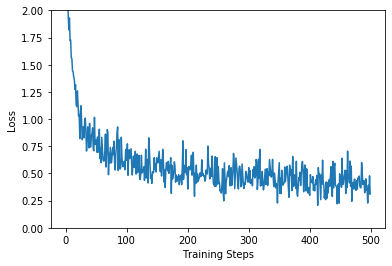

In [34]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

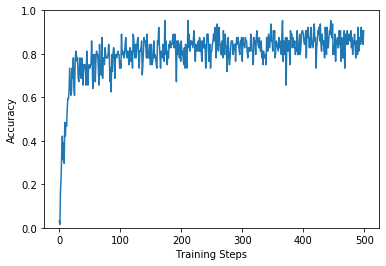

In [35]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [36]:
#*MODIFIED*
#COPY FROM CLASSIFICATION (change to np array format)
class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
class_names

array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
       'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], dtype='<U11')

Run the image batch through the model and convert the indices to class names.

In [38]:
#*Modified*
#modified variable name 
predicted_batch = model.predict(test_images_color[:30])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [39]:
#*MODIFIED*
#modified variable name 
label_id = np.argmax(test_labels_color[:30], axis=-1)

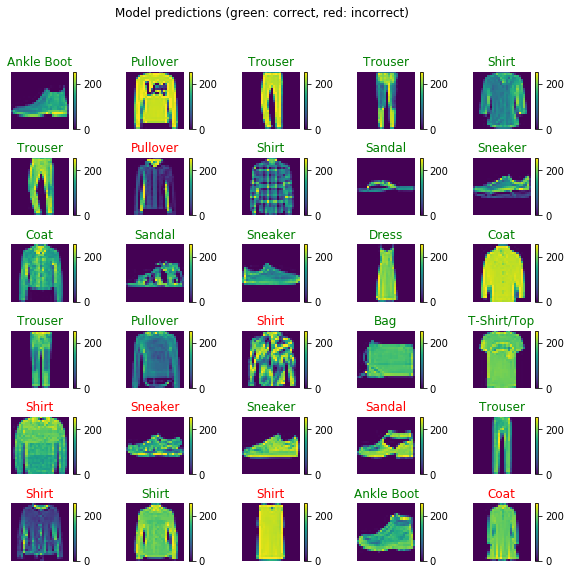

In [40]:
#*MODIFIED*
#modified variable name
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(test_images[n])
    plt.colorbar()
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [41]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1590183944/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1590183944/assets


'/tmp/saved_models/1590183944'

Now confirm that we can reload it, and it still gives the same results:

In [42]:
reloaded = tf.keras.models.load_model(export_path)

In [43]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [44]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).
